<a href="https://colab.research.google.com/github/AnIsAsPe/Estadistica_y_Probabilidad_para-CD-/blob/main/PrincipiosDeProbabilidad/Semana6/Metropolis_Hastings_para_decifrar_textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Algoritmo Metropolis Hastings para decifrar textos <h2>

El presente código es una adaptación del presentado en [este repositorio](https://github.com/svivek/mcmc-decoding-example)

El ejemplo está inspirado en la historia descrita en [The Markov Chain Monte Carlo Revolution](https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/S0273-0979-08-01238-X.pdf). 







<img src='https://pbs.twimg.com/media/DnJnUCpWwAAmPnR.jpg'>



El objetivo es decifrar los mensajes intercambiados por prisioneros, con la conjetura de que cada simbolo representa una letra o simbolo del lenguaje. La tarea es pues, encontrar ese diccionario o **clave** para codificar y decodificar los mensajes.

# Bibliotecas y Funciones

In [1]:
import re
from collections import Counter
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def limpiar_texto(texto):

    #cambiar texto a minusculas
    texto = texto.lower()
    
    # quitar tildes
    a,b = 'áéíóúü','aeiouu'
    trans = str.maketrans( a,b)
    texto = texto.translate(trans)

    # solo letras y numeros
    texto = re.sub('[^ña-z0-9 ]+' ,' ', texto).strip()  

    # remplazar multiples espacios contiguos por un solo espacio
    texto = re.sub('\s+',' ', texto)                    
    return texto

def find_between( s, first, last ):
    '''fuente: https://stackoverflow.com/questions/3368969/find-string-between-two-substrings'''
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""
def leer_texto(file, inicio=None, fin=None):
    with open(file, 'r') as f:
        if inicio is not None and fin is not None:
            libro = find_between(f.read(), inicio, fin)
        else:
            libro = f.read()
    return limpiar_texto(libro)

In [3]:
def bigram_log_probabilities(book):
    
    character_counts = Counter(book)
    bigram_counts = Counter(zip(book, book[1:]))
    bigrams = bigram_counts.keys()
    return dict(map(lambda k: [k, math.log(bigram_counts[k]) - math.log(character_counts[k[0]])], bigrams))

In [4]:
LOG_EPSILON = -30  # probabilidad muy pequeña vista como logaritmo, que se ustilizara cuando no exista probabilidad de trancisión de una letra a otra

def goodness(text, bigram_table):
    bigrams = zip(text, text[1:])
    sum = 0
    for b in bigrams:
        sum += bigram_table.get(b) or LOG_EPSILON
    return sum

In [ ]:
def MatrizTransisionLetras(book):
    
    character_counts = Counter(book)
    bigram_counts = Counter(zip(book, book[1:]))
    bigrams = bigram_counts.keys()
    MT = pd.DataFrame(LOG_EPSILON, 
                      index = [ch for ch in alphabet], 
                      columns =  [ch for ch in alphabet] )
    for row, col in bigrams:
        MT.loc[row, col] = math.log(bigram_counts[(row, col)]) - math.log(character_counts[row])
    
    fig = plt.figure(figsize = (25, 20))
    ax = sns.heatmap(np.exp(MT),
                     cmap = "mako_r",
                     cbar = False,
                     annot = True,
                     fmt=".2f",
                     square = True)
    ax.xaxis.tick_top()
    plt.show()

## Cifrado por sustitución

Es un método de cifrado para codificar y decodificar mensajes usando una clave que relaciona una letra o simbolo por otro.

Como ejemplo, se puede suponer que la clave de un cifrado está contenida en la siguiente tabla:

|original | codificado |
|---------|------------|
|a        | z          |
|n        | 4          |
|l        | 5          |
|i        | a          |
|s        | 8          |

De manera que la palabra  `analisis` puede ser codificada como `z4z5a8a8`. 

In [5]:
def code(text, key): 
    return ''.join(list(map(lambda char: key[char], text)))

In [6]:
clave = {'a': 'z', 'n': '4', 'l': '5', 'i': 'a', 's':'8'}
code('analisis', clave)

'z4z5a8a8'

Y podemos decodificar la palabra usando la clave inversa:

In [7]:
inv_clave = {v : k for k, v in clave.items()}
code('z4z5a8a8', inv_clave)

'analisis'

#¿Cómo encontrar una clave adecuada?

Si consideramos solamente el espacio en blanco, las letras en minúscula, y los números estamos hablando de 38 simbolos, y por tanto el espacio muestral en el que vive la clave es enorme.

In [8]:
alphabet = "abcdefghijklmnñopqrstuvwxyz0123456789 "

print('Total de simbolos considerados:', len(alphabet))

from math import factorial
print('Tamaño del espacio muestral en el que vive la clave que buscamos', factorial(38))

Total de simbolos considerados: 38
Tamaño del espacio muestral en el que vive la clave que buscamos 523022617466601111760007224100074291200000000


Supondremos que el lenguaje de los mensajes cifrados es el español, por tanto utilizaremos como guía las probabilidades de transición de los carácteres en español.

# ¿Cómo obtener la matriz de transición de los caracteres? 


Para aprender estas probabilidades usaremos un texto, lo más largo posible en español

Se puede calcular las probabilidades de transisión utilizando cualquier texto. Si este es suficientemente grande, podremos obtener buenas estimaciones. Usaremos Don Quijote de la Mancha, que tiene más de 2 millones de caracteres.

In [9]:
inicio = "*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"
fin = "*** END OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"

file = '/content/drive/MyDrive/Datos/DonQuijote.txt'
DonQ = leer_texto(file, inicio, fin )

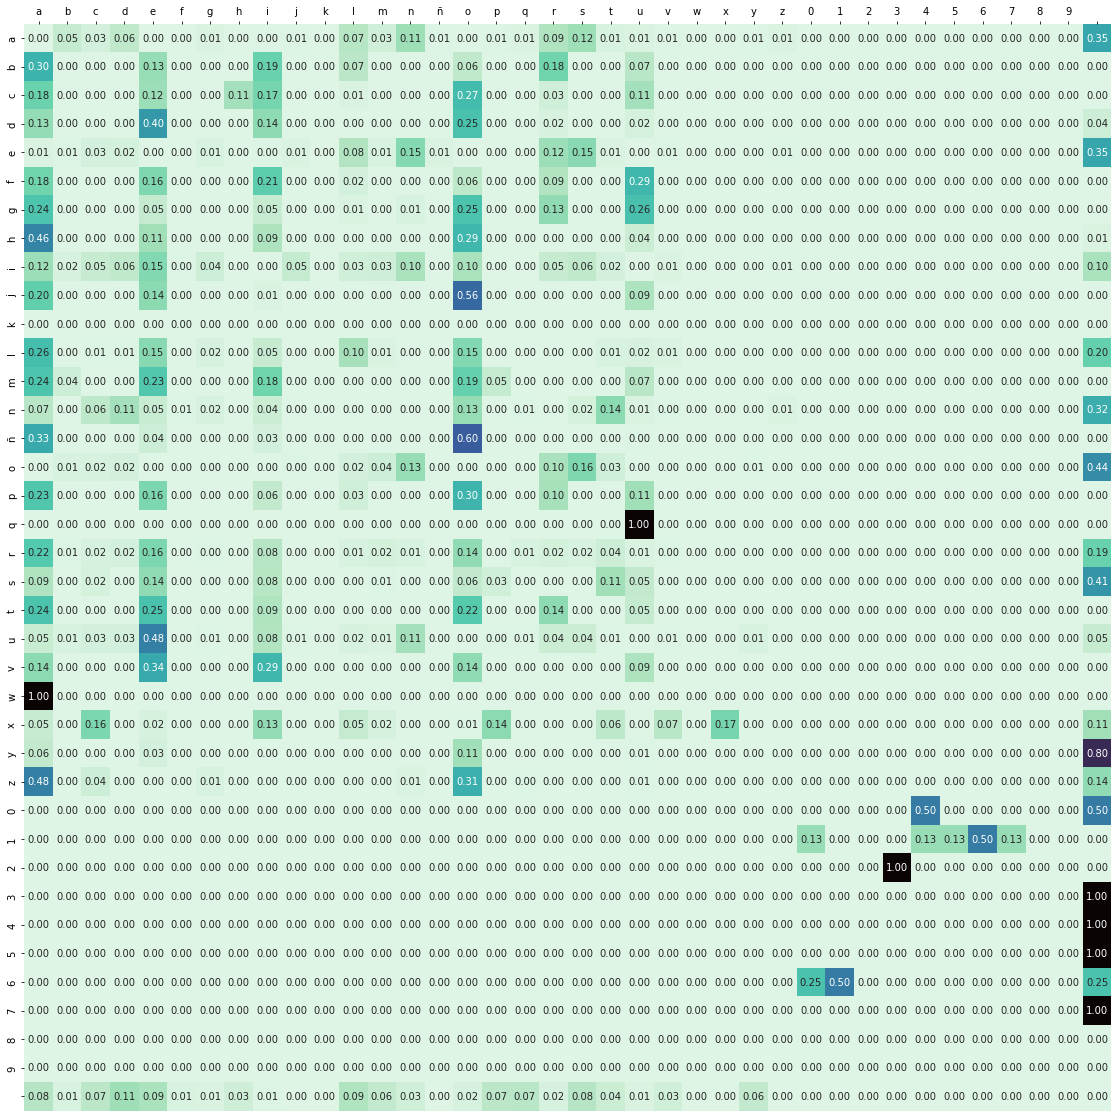

In [12]:
 MatrizTransisionLetras(DonQ)

In [13]:
bigram_table = bigram_log_probabilities(DonQ)
bigram_table

{('e', 'l'): -2.495635370118805,
 ('l', ' '): -1.633573260510028,
 (' ', 'i'): -4.937384512589171,
 ('i', 'n'): -2.3504318062150116,
 ('n', 'g'): -4.031173508631302,
 ('g', 'e'): -2.980174879019078,
 ('e', 'n'): -1.8827851415801167,
 ('n', 'i'): -3.196628842521836,
 ('i', 'o'): -2.349621480303913,
 ('o', 's'): -1.8348327937786753,
 ('s', 'o'): -2.8913442783423715,
 ('o', ' '): -0.8242763995237041,
 (' ', 'h'): -3.420071451532097,
 ('h', 'i'): -2.3957986266629003,
 ('i', 'd'): -2.801143855311272,
 ('d', 'a'): -2.023135023232147,
 ('a', 'l'): -2.6003410610565005,
 ('l', 'g'): -4.105093437001927,
 ('g', 'o'): -1.4025662217672572,
 (' ', 'd'): -2.166409555430894,
 ('d', 'o'): -1.3743360383401892,
 ('o', 'n'): -2.0723476075124374,
 ('n', ' '): -1.137340896369082,
 (' ', 'q'): -2.633056752874694,
 ('q', 'u'): 0.0,
 ('u', 'i'): -2.480561604574996,
 ('i', 'j'): -2.933481589751146,
 ('j', 'o'): -0.5809899206883387,
 ('o', 't'): -3.485054422488467,
 ('t', 'e'): -1.3776567950215597,
 ('e', ' '): 

# Calificación de las claves candidatas

Para cada secuencia de caracteres $c_1c_2c_3\cdots c_n$, estimaresmos su probabilidad de la siguiente manera

$$P(c_1c_2c_3\cdots c_n) = P(c_1) P(c_2 \mid c_1) P(c_3 \mid c_2) \cdots P(c_n \mid c_{n-1})$$

Así, la probabilidad de la palabra `analisis` se calcularía como 

 $P(a)~P(n \mid a)P(a \mid n)P(l \mid a)P(i \mid l)P(s \mid i)P(i \mid s)P(s \mid i)$.

Para hacer lo anterior necesitamos una matriz de transición de un caracter a otro, y en este sentido, para facilitar el análisis,  ignoraremos el primer caracter porque no hará practicamente diferencia en una secuencia larga.

Mediante la función "goodness", valiendonos de las probabilidades de la matriz de transisión de caracteres en español,  compararemos las secuencias decodificadas para ver con cual clave se produce una secuencia más plausible.

In [14]:
print("Log probability of 'opamc' = ",goodness("opamc", bigram_table))

Log probability of 'opamc' =  -40.784560457172915


In [15]:
print("Log probabilidad de 'campo' = " +str(goodness("campo", bigram_table)))

Log probabilidad de 'campo' = -9.40201613643682


# Implementación

## Creación del mensaje encriptado

In [43]:
plain_text = limpiar_texto(
    """Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de 
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces 
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas 
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos 
prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para 
mencionarlas había que señalarías con el dedo. Todos los años, por el mes de marzo, una familia 
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y 
timbales daban a conocer los nuevos inventos. Primero llevaron el imán. Un gitano corpulento, de 
barba montaraz y manos de gorrión, que se presentó con el nombre de Melquíades, hizo una 
truculenta demostración pública de lo que él mismo llamaba la octava maravilla de los sabios 
alquimistas de Macedonia. Fue de casa en casa arrastrando dos lingotes metálicos, y todo el 
mundo se espantó al ver que los calderos, las pailas, las tenazas y los anafes se caían de su sitio, 
y las maderas crujían por la desesperación de los clavos y los tornillos tratando de desenclavarse, 
y aun los objetos perdidos desde hacía mucho tiempo aparecían por donde más se les había 
buscado, y se arrastraban en desbandada turbulenta detrás de los fierros mágicos de Melquíades. 
"""
)

In [44]:
import random

def make_random_key():
    l = list(alphabet)
    random.shuffle(l)
    return dict(zip(alphabet, l))

In [45]:
key = make_random_key()
cipher_text = code(plain_text, key)
cipher_text

'tp0jo2cyho2cd 2xp 2cuw mq cy7cx 7oqomcd cup2v7ytv mqoc 7c0owom 7cypw 7vymoc9p mdvycjy9vycd cw 0owdywcyfp 77ycqywd cw toqyc mcfp c2pcxydw c7oc77 socyc0omo0 wc 7cjv 7octy0omdoc wyc mqom0 2cpmycy7d ycd cs vmq c0y2y2cd c9ywwoc1c0yhy9wysyc0om2qwpvdy2cyc7ycowv77ycd cpmcwvocd cybpy2cdvyuymy2cfp c2 cxw 0vxvqy9ymcxowcpmc7 0jocd cxv dwy2cxp7vdy2c97ym0y2c1c mowt 2c0otocjp so2cxw jv2qowv0o2c 7ctpmdoc wycqymcw 0v mq cfp ctp0jy2c0o2y2c0yw 0vymcd cmot9w c1cxywyct m0vomyw7y2cjy9vycfp c2 hy7ywvy2c0omc 7cd docqodo2c7o2cyho2cxowc 7ct 2cd ctywlocpmycuytv7vycd cbvqymo2cd 2ywwyxydo2cx7ymqy9yc2pc0ywxyc0 w0ycd c7ycy7d yc1c0omcpmcbwymd cy79owoqocd cxvqo2c1cqvt9y7 2cdy9ymcyc0omo0 wc7o2cmp so2cvms mqo2cxwvt woc77 sywomc 7cvtymcpmcbvqymoc0owxp7 mqocd c9yw9yctomqywylc1ctymo2cd cbowwvomcfp c2 cxw 2 mqoc0omc 7cmot9w cd ct 7fpvyd 2cjvlocpmycqwp0p7 mqycd to2qwy0vomcxp97v0ycd c7ocfp c 7ctv2toc77yty9yc7yco0qysyctywysv77ycd c7o2c2y9vo2cy7fpvtv2qy2cd cty0 domvycup cd c0y2yc mc0y2ycywwy2qwymdocdo2c7vmboq 2ct qy7v0o2c1cqod

## Busqueda de la clave

Empezaremos la busqueda de la clave adecuado, utilizando en el inicio una **clave** aleatoria que iremos cambiando por una  clave cercana, simplemente transponiendo dos caracteres seleccionados aleatoriamente.

In [46]:
clave0 = make_random_key()  # creamos una clave inicial
clave0

{'a': 'v',
 'b': 'd',
 'c': '3',
 'd': '7',
 'e': 'h',
 'f': '9',
 'g': '2',
 'h': 'x',
 'i': '6',
 'j': 'w',
 'k': 'n',
 'l': '1',
 'm': 'a',
 'n': 'b',
 'ñ': 'y',
 'o': 'z',
 'p': 'p',
 'q': '8',
 'r': 'j',
 's': 't',
 't': ' ',
 'u': 'e',
 'v': 's',
 'w': 'k',
 'x': 'l',
 'y': '0',
 'z': 'g',
 '0': 'c',
 '1': 'f',
 '2': 'q',
 '3': 'i',
 '4': 'ñ',
 '5': 'r',
 '6': '4',
 '7': 'u',
 '8': '5',
 '9': 'o',
 ' ': 'm'}

In [47]:
decoded0 =code(cipher_text, clave0) # decodificamos
decoded0

' pcwzq30xzq37mqlpmq3ekma8m30u3lmuz8za37m3epqsu0 sma8z3mu3czkzamu30pkmus0az3opma7s03w0os037m3kmczk70k309pmuu0380k7m3km z803ma39pm3qp3l07km3uz3uumtz303czazcmk3mu3wsmuz3 0cza7z3mk03ma8zacmq3pa030u7m037m3tmsa8m3c0q0q37m3o0kkz3f3c0x0ok0t03czaq8kps70q303u03zksuu037m3pa3ksz37m30dp0q37s0e0a0q39pm3qm3lkmcsls80o0a3lzk3pa3umcwz37m3lsm7k0q3lpus70q3ou0ac0q3f3mazk mq3cz z3wpmtzq3lkmwsq8zksczq3mu3 pa7z3mk0380a3kmcsma8m39pm3 pcw0q3czq0q3c0kmcs0a37m3az okm3f3l0k03 macsza0ku0q3w0os039pm3qmx0u0ks0q3cza3mu37m7z38z7zq3uzq30xzq3lzk3mu3 mq37m3 0k1z3pa03e0 sus037m3ds80azq37mq0kk0l07zq3lu0a80o03qp3c0kl03cmkc037m3u030u7m03f3cza3pa3dk0a7m30uozkz8z37m3ls8zq3f38s o0umq370o0a303czazcmk3uzq3apmtzq3satma8zq3lks mkz3uumt0kza3mu3s 0a3pa3ds80az3czklpuma8z37m3o0ko03 za80k013f3 0azq37m3dzkksza39pm3qm3lkmqma8z3cza3mu3az okm37m3 mu9ps07mq3ws1z3pa038kpcpuma8037m zq8k0csza3lpousc037m3uz39pm3mu3 sq z3uu0 0o03u03zc80t03 0k0tsuu037m3uzq3q0oszq30u9ps sq80q37m3 0cm7zas03epm37m3c0q03ma3c0q030kk0q8k0a7z37zq3usadz8mq3 m80usczq3f38z7

In [48]:
log_p0 = goodness(decoded0, bigram_table)  # evaluamos
log_p0

-34328.32207144539

In [49]:
pair = random.sample(alphabet, 2)
pair[0], pair[1]

('k', '6')

In [50]:
clave0[pair[0]] ,clave0[pair[1]]

('n', '4')

In [51]:
clave1 = clave0.copy()
clave1[pair[0]] = clave0[pair[1]]
clave1[pair[1]] = clave0[pair[0]]
clave1

{'a': 'v',
 'b': 'd',
 'c': '3',
 'd': '7',
 'e': 'h',
 'f': '9',
 'g': '2',
 'h': 'x',
 'i': '6',
 'j': 'w',
 'k': '4',
 'l': '1',
 'm': 'a',
 'n': 'b',
 'ñ': 'y',
 'o': 'z',
 'p': 'p',
 'q': '8',
 'r': 'j',
 's': 't',
 't': ' ',
 'u': 'e',
 'v': 's',
 'w': 'k',
 'x': 'l',
 'y': '0',
 'z': 'g',
 '0': 'c',
 '1': 'f',
 '2': 'q',
 '3': 'i',
 '4': 'ñ',
 '5': 'r',
 '6': 'n',
 '7': 'u',
 '8': '5',
 '9': 'o',
 ' ': 'm'}

In [52]:
decoded1 =code(cipher_text, clave1) # decodificamos
decoded1

' pcwzq30xzq37mqlpmq3ekma8m30u3lmuz8za37m3epqsu0 sma8z3mu3czkzamu30pkmus0az3opma7s03w0os037m3kmczk70k309pmuu0380k7m3km z803ma39pm3qp3l07km3uz3uumtz303czazcmk3mu3wsmuz3 0cza7z3mk03ma8zacmq3pa030u7m037m3tmsa8m3c0q0q37m3o0kkz3f3c0x0ok0t03czaq8kps70q303u03zksuu037m3pa3ksz37m30dp0q37s0e0a0q39pm3qm3lkmcsls80o0a3lzk3pa3umcwz37m3lsm7k0q3lpus70q3ou0ac0q3f3mazk mq3cz z3wpmtzq3lkmwsq8zksczq3mu3 pa7z3mk0380a3kmcsma8m39pm3 pcw0q3czq0q3c0kmcs0a37m3az okm3f3l0k03 macsza0ku0q3w0os039pm3qmx0u0ks0q3cza3mu37m7z38z7zq3uzq30xzq3lzk3mu3 mq37m3 0k1z3pa03e0 sus037m3ds80azq37mq0kk0l07zq3lu0a80o03qp3c0kl03cmkc037m3u030u7m03f3cza3pa3dk0a7m30uozkz8z37m3ls8zq3f38s o0umq370o0a303czazcmk3uzq3apmtzq3satma8zq3lks mkz3uumt0kza3mu3s 0a3pa3ds80az3czklpuma8z37m3o0ko03 za80k013f3 0azq37m3dzkksza39pm3qm3lkmqma8z3cza3mu3az okm37m3 mu9ps07mq3ws1z3pa038kpcpuma8037m zq8k0csza3lpousc037m3uz39pm3mu3 sq z3uu0 0o03u03zc80t03 0k0tsuu037m3uzq3q0oszq30u9ps sq80q37m3 0cm7zas03epm37m3c0q03ma3c0q030kk0q8k0a7z37zq3usadz8mq3 m80usczq3f38z7

In [53]:
log_p1 = goodness(decoded1, bigram_table)  # evaluamos
log_p1

-34328.32207144539

En base a lo anterior ¿Aceptamos la nueva clave propuesta?

## Algoritmo completo

In [27]:
def transpose_random(key):
    pair = random.sample(alphabet, 2)
    new_key = dict(key)
    new_key[pair[0]] = key[pair[1]]
    new_key[pair[1]] = key[pair[0]]
    return new_key

def decode(cipher_text, bigram_table, iters = 10000, print_every = 1000):
    # 1. inicializamos con una clave aleatoria
    current_key = make_random_key()  

    for i in range(0, iters):  # en cada iteración utilizaremos una nueva clave

        # 2. decodificamos la secuencia con la clave
        decoded = code(cipher_text, current_key) 

        if i % print_every == 0:
            print(str(i) + "\t" + decoded + "\n")

        # 3. evaluamos la secuencia utilizando el modelo de bigramas 
        score = goodness(decoded, bigram_table)   
               
        # 4. proponemos una nueva clave "cercana"
        changed_key = transpose_random(current_key) 

        # 5. evaluamos la nueva clave decodificando la secuencia  
        changed_score = goodness(code(cipher_text, changed_key), bigram_table)  # evaluamos la secuencia con la nueva clave propuesta

        # 6.1 si la clave propuesta da mejores resultados nos quedamos con ella para la prox iteración
        if changed_score > score:   
            current_key = changed_key

        # damos oportunidad proporcional a la relación entre la probabilidad de las dos secuencias evaluadas 
        else:  
            diff = changed_score - score
            if math.log(random.random())  < diff:
                current_key = changed_key

    decoded = code(cipher_text, current_key)
    print("Final decoded: " + decoded)
    return decoded

In [55]:
decode(cipher_text, bigram_table, 10000)

0	ibpj12y8 12yre2ube2y9qemdey84yue41d1myrey9b2w48iwemd1ye4yp1q1me4y8bqe4w8m1ysbemrw8yj8sw8yreyqep1qr8qy8xbe448yd8qreyqei1d8yemyxbey2byu8rqey41y44et1y8yp1m1peqye4yjwe41yi8p1mr1yeq8yemd1mpe2ybm8y84re8yreytewmdeyp8282yreys8qq1yzyp8 8sq8t8yp1m2dqbwr82y8y48y1qw448yreybmyqw1yrey8cb82yrw898m82yxbey2eyuqepwuwd8s8myu1qybmy4epj1yreyuwerq82yub4wr82ys48mp82yzyem1qie2yp1i1yjbet12yuqejw2d1qwp12ye4yibmr1yeq8yd8myqepwemdeyxbeyibpj82yp1282yp8qepw8myreym1isqeyzyu8q8yiempw1m8q482yj8sw8yxbey2e 848qw82yp1mye4yrer1yd1r12y412y8 12yu1qye4yie2yreyi8qo1ybm8y98iw4w8yreycwd8m12yre28qq8u8r12yu48md8s8y2byp8qu8ypeqp8yrey48y84re8yzyp1mybmycq8mrey84s1q1d1yreyuwd12yzydwis84e2yr8s8my8yp1m1peqy412ymbet12ywmtemd12yuqwieq1y44et8q1mye4ywi8mybmycwd8m1yp1qub4emd1yreys8qs8yi1md8q8oyzyi8m12yreyc1qqw1myxbey2eyuqe2emd1yp1mye4ym1isqeyreyie4xbw8re2yjwo1ybm8ydqbpb4emd8yrei12dq8pw1myubs4wp8yrey41yxbeye4yiw2i1y448i8s8y48y1pd8t8yi8q8tw448yrey412y28sw12y84xbwiw2d82yreyi8per1mw8y9beyreyp828yemyp828y8qq82dq8mr1yr12y4wmc1de2yied84wp12yzyd1

'muchos años despues frente al peloton de fusilamiento el coronel aureliano buendia habia de recordar avuella tarde remota en vue su padre lo llejo a conocer el hielo macondo era entonces una aldea de jeinte casas de barro y cañabraja construidas a la orilla de un rio de aguas diafanas vue se precipitaban por un lecho de piedras pulidas blancas y enormes como huejos prehistoricos el mundo era tan reciente vue muchas cosas carecian de nombre y para mencionarlas habia vue señalarias con el dedo todos los años por el mes de marzo una familia de gitanos desarrapados plantaba su carpa cerca de la aldea y con un grande alboroto de pitos y timbales daban a conocer los nuejos injentos primero llejaron el iman un gitano corpulento de barba montaraz y manos de gorrion vue se presento con el nombre de melvuiades hizo una truculenta demostracion publica de lo vue el mismo llamaba la octaja marajilla de los sabios alvuimistas de macedonia fue de casa en casa arrastrando dos lingotes metalicos y tod

# Otros ejemplos

In [29]:
# El principito. Tomado de https://archive.org/stream/ElPrincipitoAntoineDeSaintExupery/El_principito-_Antoine_De_Saint_Exupery_djvu.txt

plain_text = limpiar_texto(
    """Tengo poderosas razones para creer que el planeta del cual venía el principito era 
el asteroide B 612. Este asteroide ha sido visto sólo una vez con el telescopio en 
1909, por un astrónomo turco. 
Este astrónomo hizo una gran demostración de su descubrimiento en un congreso 
Internacional de Astronomía. Pero nadie le creyó a causa de su manera de vestir. 
Las personas mayores son así. Felizmente para la reputación del asteroide B 612, 
un dictador turco impuso a su pueblo, bajo pena de muerte, el vestido a la 
europea. Entonces el astrónomo volvió a dar cuenta de su descubrimiento en 1920 
y como lucía un traje muy elegante, todo el mundo aceptó su demostración. 
"""
)
cipher_text = code(plain_text, key)
cipher_text

'wr1nmybmeramisiyas6m1riybsasyfarray0oryr9yb9s1rwsyer9yfos9ytr15syr9yba51f5b5wmyrasyr9ysiwram5erypyucñyriwrysiwram5eryksyi5emyt5iwmyim9myo1sytr6yfm1yr9ywr9rifmb5myr1yc272ybmayo1ysiwam1m mywoafmyriwrysiwam1m myk56myo1synas1yer miwasf5m1yeryioyerifopa5 5r1wmyr1yo1yfm1narimy51wra1sf5m1s9yerysiwam1m 5sybramy1se5ry9ryfarjmysyfsoisyeryioy s1rasyerytriw5ay9siybraim1siy sjmariyim1ysi5ylr956 r1wrybsasy9syarbowsf5m1yer9ysiwram5erypyucñyo1ye5fwsemaywoafmy5 boimysyioyborp9myps8mybr1syery orawryr9ytriw5emysy9syroambrsyr1wm1friyr9ysiwam1m mytm9t5mysyesayfor1wsyeryioyerifopa5 5r1wmyr1yc2ñ7yjyfm my9of5syo1ywas8ry ojyr9rns1wrywmemyr9y o1emysfrbwmyioyer miwasf5m1'

In [30]:
decode(cipher_text, bigram_table, 20000)

0	l4ipgbhgj43g y b3yugi4 bhy3ybt3443brw4b4dbhdyi4lybj4dbtwydbq4izyb4dbh3zitzhzlgb43yb4dby l43gzj4bñbxaob4 l4by l43gzj4b1yb zjgbqz lgb gdgbwiybq4ubtgib4dbl4d4 tghzgb4ibaekebhg3bwiby l3gigsgblw3tgb4 l4by l3gigsgb1zugbwiybp3yibj4sg l3ytzgibj4b wbj4 twñ3zsz4ilgb4ibwibtgip34 gbzil43iytzgiydbj4by l3gigszybh43gbiyjz4bd4bt34vgbybtyw ybj4b wbsyi43ybj4bq4 lz3bdy bh43 giy bsyvg34 b giby zb94dzus4il4bhy3ybdyb34hwlytzgibj4dby l43gzj4bñbxaobwibjztlyjg3blw3tgbzshw gbyb wbhw4ñdgbñy2gbh4iybj4bsw43l4b4dbq4 lzjgbybdyb4w3gh4yb4ilgit4 b4dby l3gigsgbqgdqzgbybjy3btw4ilybj4b wbj4 twñ3zsz4ilgb4ibaeokbvbtgsgbdwtzybwibl3y24bswvb4d4pyil4blgjgb4dbswijgbyt4hlgb wbj4sg l3ytzgi

1000	lisfaebadirag ger zasigeb r enriire3uieitebt sil editenu tepiso eitebrosnobolaeir eite gliraodiecexv9eiglie gliraodiej egodaepoglaegataeus epizenaseitelitignaboaeisev616ebareuse glrasamaelurnaeiglie glrasamaejozaeus efr sedimaglr noasedieguedignucromoislaeiseusenasfrigaeoslirs noas tedie glrasamo ebiraes doietienrihae en ug edieguem sir 

'tengo poderosas razones para creer jue el planeta del cual venia el principito era el asteroide b q10 este asteroide ha sido visto solo una vez con el telescopio en 1646 por un astronomo turco este astronomo hizo una gran demostracion de su descubrimiento en un congreso internacional de astronomia pero nadie le creyo a causa de su manera de vestir las personas mayores son asi felizmente para la reputacion del asteroide b q10 un dictador turco impuso a su pueblo baño pena de muerte el vestido a la europea entonces el astronomo volvio a dar cuenta de su descubrimiento en 1604 y como lucia un trañe muy elegante todo el mundo acepto su demostracion'

In [31]:
# La liebre y la tortuga. Tomado de https://psicologiaymente.com/cultura/fabulas-de-esopo

plain_text = limpiar_texto(
    """Un día una liebre orgullosa y veloz, vió como una tortuga caminaba por el camino y se le acercó. La liebre empezó a burlarse de la lentitud del otro animal y de la longitud de sus patas. Sin embargo, la tortuga le respondió que estaba segura de que a pesar de la gran velocidad de la liebre era capaz de ganarla en una carrera.
La liebre, segura de su victoria y considerando el reto imposible de perder, aceptó. Ambos pidieron a la zorra que señalara la meta, a lo que esta aceptó, al igual que al cuervo para que hiciera de juez.
Al llegar el día de la competición, al empezar la carrera la liebre y la tortuga salieron al mismo tiempo. La tortuga avanzaba sin detenerse, pero lentamente.
La liebre era muy veloz, y viendo que sacaba una gran ventaja a la tortuga decidió ir parándose y descansando de vez en cuando. Pero en una de las ocasiones la liebre se quedó dormida. La tortuga, poco a poco, siguió avanzando.
Cuando la liebre despertó, se encontró con que la tortuga estaba a punto de cruzar la meta. Aunque echó a correr fue demasiado tarde y finalmente la tortuga ganó la carrera".
Esta fábula nos enseña que el trabajo duro, la perseverancia, la constancia y el esfuerzo nos llevarán a nuestras metas, aunque sea poco a poco, si no nos rendimos. También nos permite ver cómo la arrogancia, la falta de constancia y el exceso de seguridad en uno mismo nos puede llevar a perder oportunidades y a no alcanzar nuestras metas.
"""
)
cipher_text = code(plain_text, key)
cipher_text

'o1ye5syo1sy95rparymano99misyjytr9m6yt5myfm myo1sywmawonsyfs 51spsybmayr9yfs 51myjyiry9rysfrafmy9sy95rparyr br6mysypoa9sairyery9sy9r1w5woeyer9ymwamys15 s9yjyery9sy9m1n5woeyeryioiybswsiyi51yr psanmy9sywmawonsy9ryaribm1e5my0oryriwspsyirnoasyery0orysybrisayery9synas1ytr9mf5eseyery9sy95rparyrasyfsbs6yeryns1sa9syr1yo1syfsaarasy9sy95rparyirnoasyeryioyt5fwma5syjyfm1i5eras1emyr9yarwmy5 bmi5p9ryerybraeraysfrbwmys pmiyb5e5ram1ysy9sy6maasy0oryirxs9sasy9sy rwsysy9my0oryriwsysfrbwmys9y5nos9y0orys9yforatmybsasy0oryk5f5rasyery8or6ys9y99rnsayr9ye5syery9syfm brw5f5m1ys9yr br6say9syfsaarasy9sy95rparyjy9sywmawonsyis95ram1ys9y 5i myw5r bmy9sywmawonsysts16spsyi51yerwr1rairybramy9r1ws r1wry9sy95rparyrasy ojytr9m6yjyt5r1emy0oryisfspsyo1synas1ytr1ws8sysy9sywmawonsyerf5e5my5aybsas1emiryjyerifs1is1emyerytr6yr1yfos1emybramyr1yo1syery9siymfsi5m1riy9sy95rparyiry0oremyema 5esy9sywmawonsybmfmysybmfmyi5no5mysts16s1emyfos1emy9sy95rparyeribrawmyiryr1fm1wamyfm1y0ory9sywmawonsyriwspsysybo1wmyeryfao6say9sy rwsyso10oryrfkm

In [32]:
decode(cipher_text, bigram_table, 10000)

0	c2sgq3sc23smqj04jsi4xcmmif3sbs1jmiys1qisaiñisc23s9i49cx3sa3ñq2303s7i4sjmsa3ñq2isbsfjsmjs3aj4aism3smqj04jsjñ7jyis3s0c4m34fjsgjsm3smj29q9cgsgjmsi94is32qñ3msbsgjsm3smi2xq9cgsgjsfcfs7393fsfq2sjñ034xism3s9i49cx3smjs4jf7i2gqistcjsjf9303sfjxc43sgjstcjs3s7jf34sgjsm3sx432s1jmiaqg3gsgjsm3smqj04jsj43sa373ysgjsx3234m3sj2sc23sa344j43sm3smqj04jsfjxc43sgjsfcs1qa9i4q3sbsai2fqgj432gisjms4j9isqñ7ifq0mjsgjs7j4gj4s3aj79is3ñ0ifs7qgqj4i2s3sm3syi443stcjsfjh3m343sm3sñj93s3smistcjsjf93s3aj79is3msqxc3mstcjs3msacj41is7343stcjs6qaqj43sgjsvcjys3msmmjx34sjmsgq3sgjsm3saiñ7j9qaqi2s3msjñ7jy34sm3sa344j43sm3smqj04jsbsm3s9i49cx3sf3mqj4i2s3msñqfñis9qjñ7ism3s9i49cx3s3132y303sfq2sgj9j2j4fjs7j4ismj293ñj29jsm3smqj04jsj43sñcbs1jmiysbs1qj2gistcjsf3a303sc23sx432s1j293v3s3sm3s9i49cx3sgjaqgqisq4s73432gifjsbsgjfa32f32gisgjs1jysj2sac32gis7j4isj2sc23sgjsm3fsia3fqi2jfsm3smqj04jsfjstcjgisgi4ñqg3sm3s9i49cx3s7iais3s7iaisfqxcqis3132y32gisac32gism3smqj04jsgjf7j49isfjsj2ai294isai2stcjsm3s9i49cx3sjf9303s3s7c29isgjsa4cy34sm3sñj93s3c2tcjsja6

'un dia una liebre orgullosa y veloz vio como una tortuga caminaba por el camino y se le acerco la liebre empezo a burlarse de la lentitud del otro animal y de la longitud de sus patas sin embargo la tortuga le respondio fue estaba segura de fue a pesar de la gran velocidad de la liebre era capaz de ganarla en una carrera la liebre segura de su victoria y considerando el reto imposible de perder acepto ambos pidieron a la zorra fue señalara la meta a lo fue esta acepto al igual fue al cuervo para fue xiciera de juez al llegar el dia de la competicion al empezar la carrera la liebre y la tortuga salieron al mismo tiempo la tortuga avanzaba sin detenerse pero lentamente la liebre era muy veloz y viendo fue sacaba una gran ventaja a la tortuga decidio ir parandose y descansando de vez en cuando pero en una de las ocasiones la liebre se fuedo dormida la tortuga poco a poco siguio avanzando cuando la liebre desperto se encontro con fue la tortuga estaba a punto de cruzar la meta aunfue ecxo